In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

# Research Question
The intent of this analysis is to use clustering methodologies and data science visualization tools to determine whether relationships exist in an unlabeled dataset containing crime statistics for the 50 states in the U.S. 

This exploration will consist of the following:  
* Loading the data  
* Exploratory data analysis (EDA)  
* Data preprocessing  
* Model building
   - Hierarchical Clustering  
   - K-Means Clustering  
* Model evaluation / visualizations
   - Pairplots
   - Geographic chloropleth
* Conclusion / future analyses

The conclusion will assess the efficacy of determining relationships amongst the data using clustering and derive further routes of exploration based on any questions that might remain once the analysis is completed.

# Load the Data
https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html  
This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percentage of the population living in urban areas.

Of the variables, one is a string (state name, which will be used as the index of the dataframe) and four are numerical.

In [2]:
crimedf = pd.read_csv("violent_crime.csv",index_col=0)
crimedf = crimedf[["UrbanPop","Murder","Assault","Rape"]] #Rearrange columns to group crime types
crimedf["Total"] = crimedf.iloc[:,1:].sum(axis=1)
crimedf.sort_values("Total",ascending=False,inplace=True)
crimedf.shape
crimedf.head(8)

(50, 5)

,UrbanPop,Murder,Assault,Rape,Total
Florida,80,15.4,335,31.9,382.3
North Carolina,45,13.0,337,16.1,366.1
Maryland,67,11.3,300,27.8,339.1
Arizona,80,8.1,294,31.0,333.1
New Mexico,70,11.4,285,32.1,328.5
California,91,9.0,276,40.6,325.6
Alaska,48,10.0,263,44.5,317.5
South Carolina,48,14.4,279,22.5,315.9


In [3]:
#Check for null values and return dtypes of each column
crimedf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Florida to North Dakota
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   UrbanPop  50 non-null     int64  
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   Rape      50 non-null     float64
 4   Total     50 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.3+ KB


# Exploratory data analysis (EDA)
First we will create an overlaid bar plot of the total crime and percentage of urban population by state to get a feel for the dataset. We will also create a stacked bar plot to show proportionality of the crime types in the dataset.

We will then output some descriptive statistics of the continuous columns of the dataset using pandas.describe().

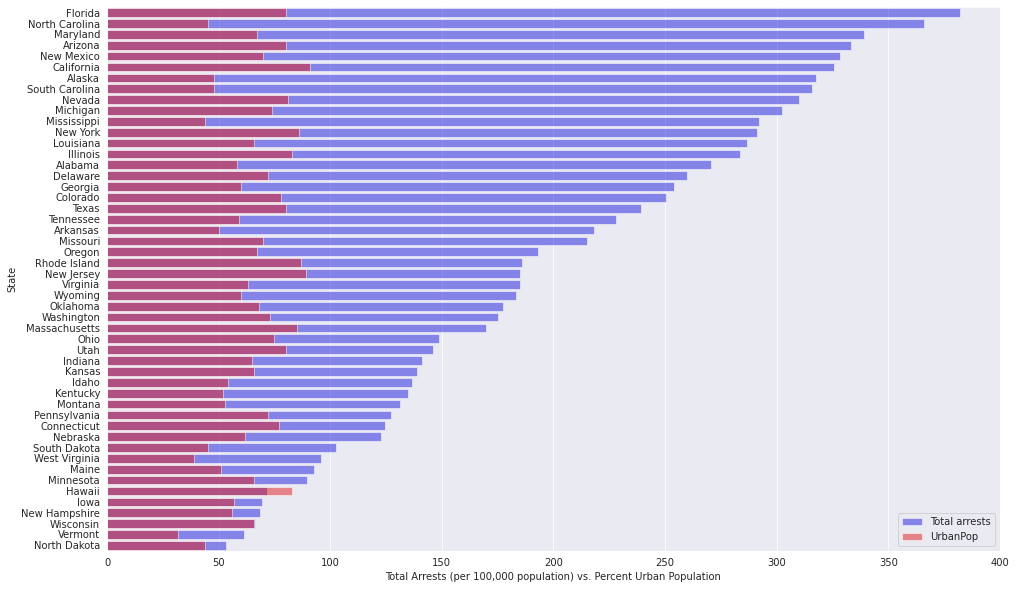

In [4]:
fig,ax = plt.subplots(figsize=(16,10));

ax = sns.barplot(data=crimedf,x="Total",y=crimedf.index,label="Total arrests",color="b");
ax = sns.barplot(data=crimedf,x="UrbanPop",y=crimedf.index,label="UrbanPop",color="r");

#Adjust transparency of overlaid bars
for bar in list(ax.containers[0]+ax.containers[1]):
    bar.set_alpha(0.5);

ax.legend(loc="lower right",frameon=True);
ax.set(xlim=(0,400),ylabel="State",xlabel="Total Arrests (per 100,000 population) vs. Percent Urban Population");

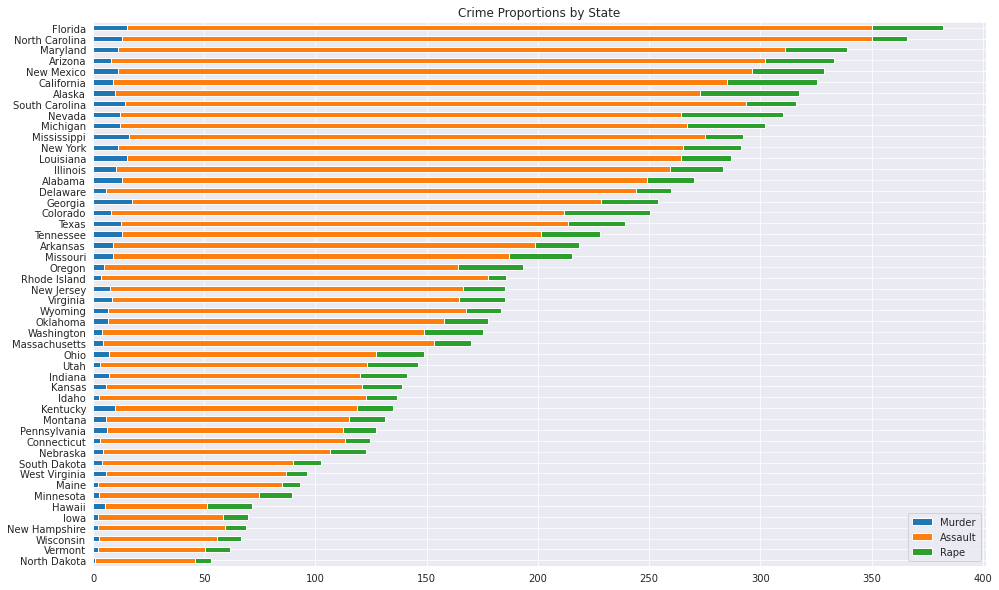

In [5]:
crimedf.iloc[:,1:-1].plot(kind = 'barh',stacked = True,
                          figsize=(16,10),
                          title = 'Crime Proportions by State').invert_yaxis()

In [6]:
crimedf.describe().T

,count,mean,std,min,25%,50%,75%,max
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0
Total,50.0,199.780,93.372967,53.1,128.250,185.20,285.800,382.3


We can immediately see that the variances of the input columns vary significantly from one-another.  
Given this, scaling might be an appropriate choice prior to model fitting.

Based on a cursory look at the stacked horizontal bar plot of total crime vs. percentage of urban population, no immediate trends stick out vis a vis a relationship between the two variables. However, a slight geographic trend can be observed, as the majority of the top 20 most crime-ridden states are from the American South.

Next we will determine any correlation between the features using a corrplot and associated heatmap.

          UrbanPop    Murder   Assault      Rape
UrbanPop  1.000000  0.069573  0.258872  0.411341
Murder    0.069573  1.000000  0.801873  0.563579
Assault   0.258872  0.801873  1.000000  0.665241
Rape      0.411341  0.563579  0.665241  1.000000


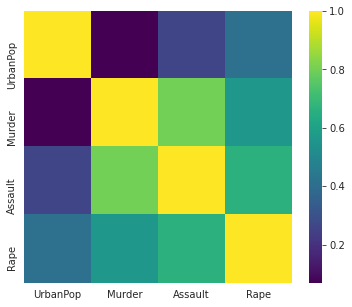

In [7]:
plt.figure(figsize=(6,5))
print(crimedf.iloc[:,:-1].corr())
sns.heatmap(crimedf.iloc[:,:-1].corr(),cmap="viridis");

The correlation heatmap indicates that all the features have some positive correlation with all the other features, with the strongest-correlated features being Murder and Assault.

Perhaps most surprisingly, however, is the low correlation (Pearson's coefficient close to 0) between UrbanPop and Murder. This revelation is surprising because of the fact that many people assume murders are more likely to occur within or near urban centers, whereas the data so far seems to indicate that many people in the United States enjoy killing each other regardless of where they live.

Note: for clustering analyses, feature collinearity is not an issue, as clustering methodologies do not rely on linear assumptions, but rather user-defined distance metrics.  
(https://stackoverflow.com/questions/59494747/does-correlation-important-factor-in-unsupervised-learning-clustering)

Next we will generate a pairplot to further visualize the features and their relationships with one-another.

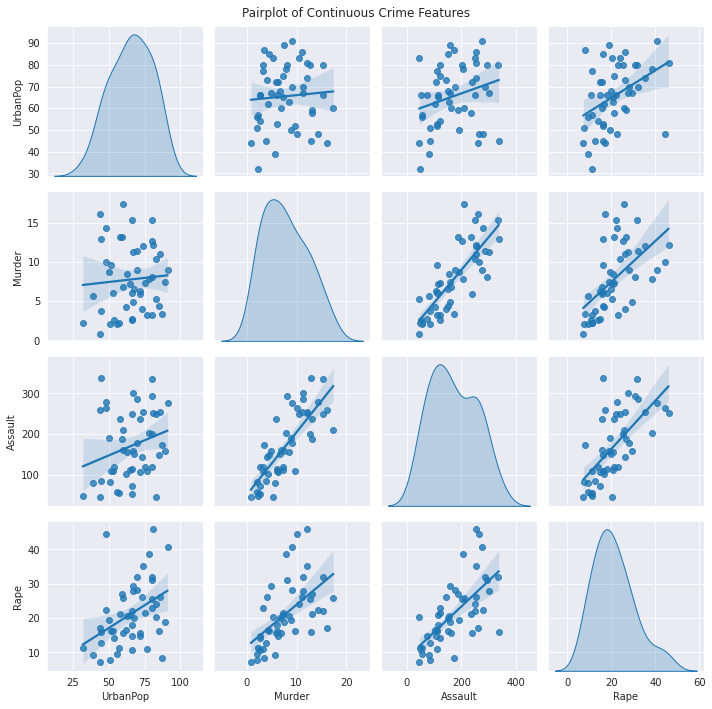

In [8]:
sns.pairplot(crimedf.iloc[:,:-1],kind="reg",diag_kind="kde");
plt.suptitle("Pairplot of Continuous Crime Features");
plt.tight_layout();

From the KDE plots on the main diagonal we can deduce that all the feature variables are approximately normally distributed. Though normality is not a necessary assumption of K-Means Clustering, the model is sensitive to differences in variance of the input features, confirming the need for scaling prior to model fitting.

The reg plots off the main diagonal confirm the conclusions reached from analysis of the correlation heatmap, with Murder/Assault showing the strongest relationship and UrbanPop/Murder showing the weakest.

# Data Preprocessing
Not much preprocessing is required for this particular dataset, as all the features are numeric and there are no missing values.

Most applications of clustering methods in data science and machine learning require the features to first be scaled prior to being used as inputs to the model. This intuitively makes sense, as the scales of each of the features could vary from one-another and could therefore have imbalanced influences on the resulting clusters.

For this exploration, we will make use of the preprocessing library in sklearn, specifically StandardScaler(), in order to scale our input columns prior to clustering.

In [9]:
#Remove "Total" column, as it was only useful for the preceding EDA section
crimedf.drop(columns=["Total"],inplace=True)
crimedf.head(5)

,UrbanPop,Murder,Assault,Rape
Florida,80,15.4,335,31.9
North Carolina,45,13.0,337,16.1
Maryland,67,11.3,300,27.8
Arizona,80,8.1,294,31.0
New Mexico,70,11.4,285,32.1


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(crimedf),columns=crimedf.columns,index=crimedf.index)
X.head()

,UrbanPop,Murder,Assault,Rape
Florida,1.009122,1.765415,1.990786,1.150530
North Carolina,-1.433428,1.208794,2.015028,-0.553480
Maryland,0.101889,0.814521,1.566544,0.708350
Arizona,1.009122,0.072361,1.493817,1.053466
New Mexico,0.311251,0.837714,1.384726,1.172100


# Model Building
We are now ready to build our K-Means clustering model on the processed crime data.  
In order to do this, we will first generate a scree plot of the errors (inertia) based on cluster numbers in range(1,16) in order to determine the ideal input number of clusters to the model.

In [11]:
from sklearn.cluster import KMeans

inertia = []
for num in range(1,16):
    model = KMeans(num,random_state=2357).fit(X)
    inertia.append(model.inertia_)

scree = pd.DataFrame({"numClusters":range(1,16),"inertia":inertia})
scree.head()

,numClusters,inertia
0,1,200.000000
1,2,104.961633
2,3,80.115640
3,4,57.672852
4,5,49.943064


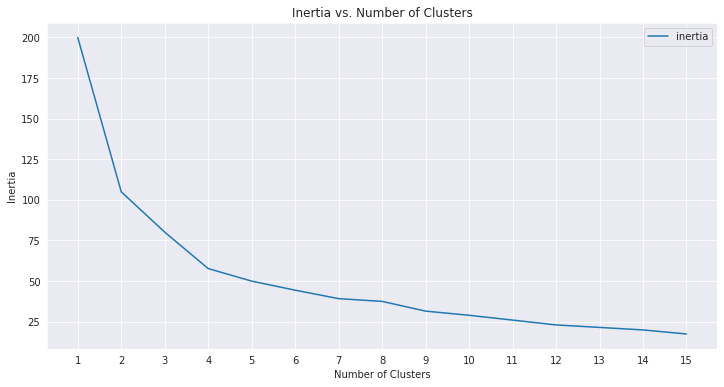

In [12]:
scree.plot(x="numClusters",y="inertia",
           figsize=(12,6),
           title="Inertia vs. Number of Clusters",xlabel="Number of Clusters",ylabel="Inertia",xticks=range(1,16));

The scree plot (AKA elbow plot) of inertia vs. the number of clusters used as an input to the KMeans constructor indicates that the ideal number of clusters for our dataset would be 4.  
This is because the plot shows an "elbow" at x=4, indicating that the reduction of inertia that can be achieved by increasing the number of clusters beyond 4 does not outweigh the cost of adding to the complexity of the model.

To further confirm this, we will construct a dendrogram using hierarchical clustering to visually observe the ideal number of clusters for our dataset.

In [13]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

agg_clust = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(X)
linkage = hierarchy.linkage(agg_clust.children_,'ward')

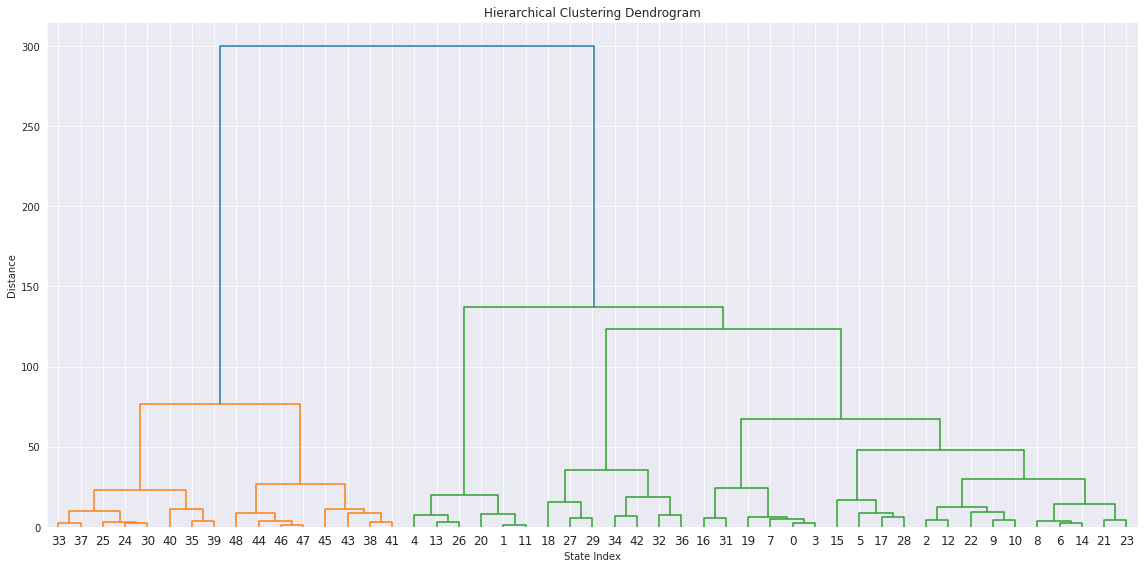

In [14]:
plt.figure(figsize=(16,8))
plt.title('Hierarchical Clustering Dendrogram');
dendrogram(linkage,orientation="top");
plt.xlabel("State Index");
plt.ylabel("Distance");
plt.xticks(fontsize=12,rotation='horizontal');
plt.tight_layout();

We can see from the dendrogram that a distance of ~75 yields 4 clusters (determined by slicing the tree with a horizontal line at distance=75 and counting the intersections). No other splits are made until a distance of ~125, confirming the conclusion reached by the scree plot.

In [15]:
#Fit model and add cluster labels to crimedf
model = KMeans(4,random_state=2357).fit(X)
crimedf["Cluster"] = model.labels_
crimedf["Cluster"] = crimedf["Cluster"].astype(str)
crimedf.head(10)

,UrbanPop,Murder,Assault,Rape,Cluster
Florida,80,15.4,335,31.9,1
North Carolina,45,13.0,337,16.1,3
Maryland,67,11.3,300,27.8,1
Arizona,80,8.1,294,31.0,1
New Mexico,70,11.4,285,32.1,1
California,91,9.0,276,40.6,1
Alaska,48,10.0,263,44.5,1
South Carolina,48,14.4,279,22.5,3
Nevada,81,12.2,252,46.0,1
Michigan,74,12.1,255,35.1,1


# Model Evaluation / Visualizations
Because K-Means was fit to 4 feature variables, visualization of clusters/cluster centers is not doable.  
However, we can reproduce a pairplot with "Cluster" as the hue to visualize groupings based on pairwise features.

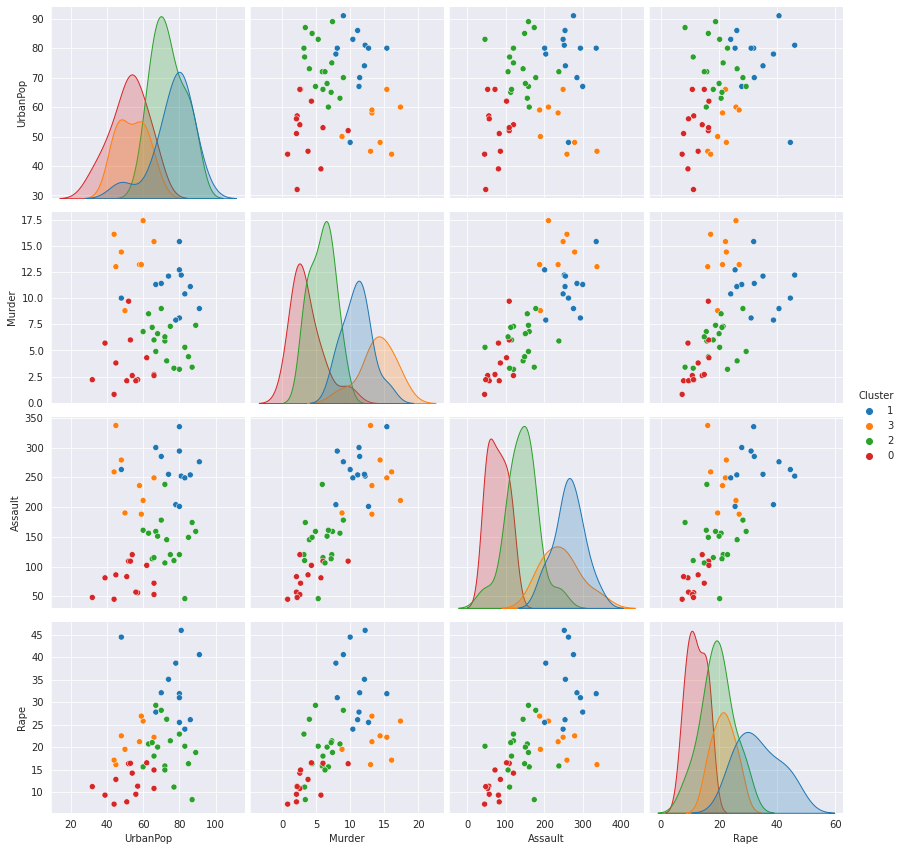

In [16]:
sns.pairplot(crimedf,diag_kind="kde",hue="Cluster",
             height=3,aspect=1.0);

Based on the densities along the main diagonal, Murder and Assault appear to be the most influential features in determining cluster centers. Even though all of the clusters show some degree of overlap, these two features have the most distinct distributions between clusters.

A decent degree of spread and overlap exists in the pairwise scatterplots between each of the clusters for all of the variables, most notably for Rape. Again, however, the above visualization is compressing a 4-dimensional clustering model into 2 dimensions, so steadfast conclusions about the strength and validity of the model based solely on the pairwise scatterplots is not feasible.

The next step of our analysis will be examining whether a geographic relationship exists amongst the clusters.

## Geoplot
The geographic data necessary to define state geometries is sourced from COMP 4433 Data Visualization, Assignment 5.  
It has been saved to the directory as states.pkl.

In [17]:
import geoplot
from shapely.geometry import Polygon

states = pd.read_pickle("states.pkl")
states.head()

,scalerank,featurecla,adm1_code,geometry
State,,,,
MN,2,Admin-1 scale rank,USA-3514,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
MT,2,Admin-1 scale rank,USA-3515,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
ND,2,Admin-1 scale rank,USA-3516,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
HI,2,Admin-1 scale rank,USA-3517,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
ID,2,Admin-1 scale rank,USA-3518,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."


In [18]:
#Map index of state abbreviations to state names in order to join crimesdf Cluster column
abbv = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California",
        "CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia",
        "HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas",
        "KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts",
        "MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana",
        "NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico",
        "NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
        "OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota",
        "TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington",
        "WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
states.index = states.index.map(abbv)
states.head()

,scalerank,featurecla,adm1_code,geometry
State,,,,
Minnesota,2,Admin-1 scale rank,USA-3514,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
Montana,2,Admin-1 scale rank,USA-3515,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
North Dakota,2,Admin-1 scale rank,USA-3516,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
Hawaii,2,Admin-1 scale rank,USA-3517,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
Idaho,2,Admin-1 scale rank,USA-3518,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."


In [19]:
states = states.join(crimedf.Cluster)
states.head()

,scalerank,featurecla,adm1_code,geometry,Cluster
State,,,,,
Minnesota,2,Admin-1 scale rank,USA-3514,"POLYGON ((-89.59941 48.01027, -89.48888 48.013...",0
Montana,2,Admin-1 scale rank,USA-3515,"POLYGON ((-111.19419 44.56116, -111.29155 44.7...",0
North Dakota,2,Admin-1 scale rank,USA-3516,"POLYGON ((-96.60136 46.35136, -96.53891 46.199...",0
Hawaii,2,Admin-1 scale rank,USA-3517,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",2
Idaho,2,Admin-1 scale rank,USA-3518,"POLYGON ((-111.04973 44.48816, -111.05025 42.0...",0


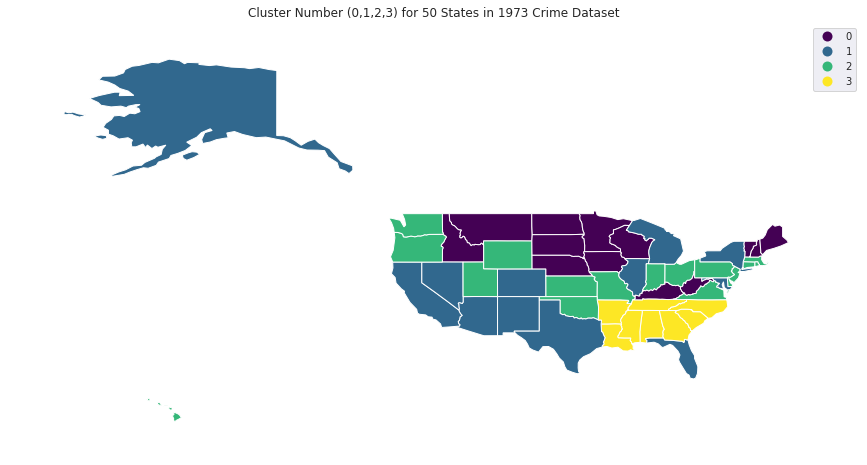

In [20]:
ax = geoplot.choropleth(states,hue=states.Cluster,cmap="viridis",figsize=(20,8),
                        legend=True);
ax.set_title("Cluster Number (0,1,2,3) for 50 States in 1973 Crime Dataset");

# Conclusion
Surprisingly, a very clear geographic relationship exists amongst the clusters. 

Cluster 3, which tended to have higher crime numbers across the board, is neatly localized in the Deep South.  
Cluster 1 also had relatively high crime numbers, which could explain the grouping of high-population states within it (eg. Texas, Florida, California, New York, Illinois).  
More rural states were grouped into Clusters 0 and 2, with Cluster 0 tending to be further North than Cluster 2.

# Future Analysis

For future analyses, supplementary datasets could be added to the model, including variables such as total population in 1973, and metrics such as happiness index or state-wide GDP.

With the addition of other variables, perhaps PCA could be employed in the preprocessing section in order to reduce the number of input features while preserving the variance, and possibly leading to better cluster visualization depending on the number of returned components.